In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
from datetime import time, timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Carga y limpieza de Datos
file_path = 'SOLUSDT_1m_7y.csv'
print (f"Cargando datos desde: {file_path}")
# Carga todo el CSV a un Df
data = pd.read_csv(file_path)
# Convierte el date de data al date del DF con formato de Fecha
data['date'] = pd.to_datetime(data['Date'])
# Crea un indice temporal usando la fecha
data.set_index('date', inplace=True)
# Ordena por fecha
data = data.sort_index()
# Ahora copia solo las columnas que nos interesan
data = data[['open', 'high', 'low', 'close', 'volume']]
# Elimina filas con valores nulos
data = data.dropna()
# Elimina filas con volumenes negativos
data = data[(data['volume'] > 0)]
# Elimina filas con valores negativos
data = data[(data['open'] > 0) & (data['high'] > 0) & (data['low'] > 0) & (data['close'] > 0)]
# Elimina filas donde el high < low
data = data[(data['high'] >= data['low'])]
print(f"Datos cargados: {data.shape[0]} filas y {data.shape[1]} columnas")
data.head()

Cargando datos desde: SOLUSDT_1m_7y.csv
Datos cargados: 2740208 filas y 5 columnas


,open,high,low,close,volume
date,,,,,
2020-08-11 06:00:00+00:00,2.8500,2.8500,2.8500,2.8500,3.60
2020-08-11 06:03:00+00:00,3.4699,3.4700,3.0003,3.0003,3410.31
2020-08-11 06:04:00+00:00,3.1852,3.1852,3.1852,3.1852,313.95
2020-08-11 06:05:00+00:00,3.1846,3.4700,3.1846,3.4700,1054.37
2020-08-11 06:06:00+00:00,3.2150,3.2150,3.1890,3.2000,892.21


In [3]:
def get_trading_day(timestamp, open_hour=0, open_minute=0):
    """
    Determina el día de trading basado en horario de apertura
    Si la vela es ANTES del horario de apertura, pertenece al día anterior
    """
    # Crear datetime con el horario de apertura del día actual
    open_time = timestamp.replace(hour=open_hour, minute=open_minute, second=0, microsecond=0)

    if timestamp < open_time:
        # Pertenece al día de trading anterior
        return (timestamp - timedelta(days=1)).date()
    else:
        # Pertenece al día de trading actual
        return timestamp.date()

def calculate_orb_general_robust(df, open_hour=0, open_minute=0, or_duration_minutes=60):
    """
    Versión robusta que maneja timezones automáticamente
    """
    # Asumimos que df YA TIENE la columna 'trading_day'
    results = []

    # Procesar cada día de trading
    for trading_day, day_data in df.groupby('trading_day'):
        day_data = day_data.sort_index()

        # Determinar timezone del índice
        index_tz = day_data.index.tz

        # Crear open_datetime con timezone consistente
        if index_tz is not None:
            open_datetime = pd.Timestamp(
                datetime.combine(trading_day, time(open_hour, open_minute)),
                tz=index_tz
            )
        else:
            open_datetime = datetime.combine(trading_day, time(open_hour, open_minute))

        orb_end_time = open_datetime + timedelta(minutes=or_duration_minutes)

        # Usar slicing por rango temporal
        orb_data = day_data.loc[open_datetime:orb_end_time]

        if len(orb_data) > 0:
            orb_high = orb_data['high'].max()
            orb_low = orb_data['low'].min()

            results.append({
                'trading_day': trading_day,
                'orb_high': orb_high,
                'orb_low': orb_low,
                'orb_start_time': open_datetime,
                'orb_end_time': orb_end_time,
                'orb_bars_count': len(orb_data)
            })

    return pd.DataFrame(results)

def calculate_orb_non_continuous(df, open_hour=0, open_minute=0, or_duration_minutes=60, min_bars=3):
    """
    Versión para datos no continuos - usa las primeras X velas después de la apertura
    """
    df_processed = df.copy()
    results = []

    for trading_day, day_data in df_processed.groupby('trading_day'):
        day_data = day_data.sort_index()

        # Determinar timezone
        index_tz = day_data.index.tz

        # Crear horario de apertura
        if index_tz is not None:
            open_datetime = pd.Timestamp(
                datetime.combine(trading_day, time(open_hour, open_minute)),
                tz=index_tz
            )
        else:
            open_datetime = datetime.combine(trading_day, time(open_hour, open_minute))

        # Estrategia 1: Usar ventana temporal estricta
        orb_end_time = open_datetime + timedelta(minutes=or_duration_minutes)
        orb_data_temporal = day_data[(day_data.index >= open_datetime) &
                                   (day_data.index <= orb_end_time)]

        # Estrategia 2: Usar primeras N velas del día
        orb_data_first_bars = day_data[day_data.index >= open_datetime].head(30)  # primeras 30 velas

        # Elegir la estrategia que tenga más datos
        if len(orb_data_temporal) >= len(orb_data_first_bars):
            orb_data = orb_data_temporal
            method = "temporal"
        else:
            orb_data = orb_data_first_bars
            method = "first_bars"

        # Verificar que tenemos suficientes datos
        if len(orb_data) >= min_bars:
            orb_high = orb_data['high'].max()
            orb_low = orb_data['low'].min()

            results.append({
                'trading_day': trading_day,
                'orb_high': orb_high,
                'orb_low': orb_low,
                'orb_start_time': open_datetime,
                'orb_end_time': orb_end_time,
                'orb_bars_count': len(orb_data),
                'method_used': method
            })
            print(f"Día {trading_day}: {len(orb_data)} velas en OR, método: {method}")
        else:
            print(f"⚠️ Día {trading_day}: Solo {len(orb_data)} velas en OR (mínimo requerido: {min_bars}) - SKIP")

    return pd.DataFrame(results)

In [4]:
def merge_orb_levels_skip_first_day(df, zone: str = "MIDNIGHT"):
    """
    Versión que salta el primer día incompleto del dataset
    """
    # Calcular trading_day primero
    df_with_trading_day = df.copy()

    if zone == "MIDNIGHT":
        open_hour, open_minute = 0, 0
    elif zone == "AMERICA":
        open_hour, open_minute = 14, 30
    elif zone == "EUROPE":
        open_hour, open_minute = 8, 0
    else:
        raise ValueError("Zona no reconocida. Use 'MIDNIGHT', 'AMERICA' o 'EUROPE'.")

    # Calcular trading_day
    index_tz = df_with_trading_day.index.tz

    def get_trading_day_robust(timestamp, open_hour, open_minute):
        if index_tz is not None:
            open_time = pd.Timestamp(
                datetime.combine(timestamp.date(), time(open_hour, open_minute)),
                tz=index_tz
            )
        else:
            open_time = datetime.combine(timestamp.date(), time(open_hour, open_minute))

        if timestamp < open_time:
            return (timestamp - timedelta(days=1)).date()
        else:
            return timestamp.date()

    df_with_trading_day['trading_day'] = df_with_trading_day.index.map(
        lambda x: get_trading_day_robust(x, open_hour, open_minute)
    )

    # ✅ IDENTIFICAR y EXCLUIR el primer día incompleto
    all_trading_days = sorted(df_with_trading_day['trading_day'].unique())

    if len(all_trading_days) > 1:
        first_complete_day = all_trading_days[1]  # Saltar el día 0
        print(f"Saltando primer día incompleto: {all_trading_days[0]}")
        print(f"Empezando con día completo: {first_complete_day}")

        # Filtrar DataFrame para excluir primer día
        df_filtered = df_with_trading_day[df_with_trading_day['trading_day'] >= first_complete_day]
    else:
        df_filtered = df_with_trading_day
        print("⚠️ Solo hay un día en el dataset, no se puede saltar")

    # Calcular ORB normal (horario fijo) con datos filtrados
    orb_levels_df = calculate_orb_general_robust(df_filtered, open_hour, open_minute, 60)

    print(f"\nORB calculado para {len(orb_levels_df)} días (excluyendo primer día incompleto)")

    # Aplicar a DataFrame ORIGINAL (para mantener todos los datos)
    result_df = df_with_trading_day.copy()
    result_df['orb_high'] = np.nan
    result_df['orb_low'] = np.nan
    result_df['in_opening_range'] = False
    result_df['after_opening_range'] = False

    # Aplicar niveles ORB solo a días que SÍ calcularon ORB
    for _, orb_row in orb_levels_df.iterrows():
        trading_day = orb_row['trading_day']
        orb_high = orb_row['orb_high']
        orb_low = orb_row['orb_low']
        orb_start = orb_row['orb_start_time']
        orb_end = orb_row['orb_end_time']

        mask_trading_day = (result_df['trading_day'] == trading_day)
        mask_in_range = (result_df.index >= orb_start) & (result_df.index <= orb_end)
        mask_after_range = (result_df.index > orb_end)

        result_df.loc[mask_trading_day & mask_in_range, 'in_opening_range'] = True
        result_df.loc[mask_trading_day & mask_after_range, 'after_opening_range'] = True
        result_df.loc[mask_trading_day, 'orb_high'] = orb_high
        result_df.loc[mask_trading_day, 'orb_low'] = orb_low

    return result_df

# Ejecutar la función
print("=== CALCULANDO ORB CON PRIMER DÍA EXCLUIDO ===")
data_with_orb = merge_orb_levels_skip_first_day(data, zone="MIDNIGHT")

# Verificar resultados
print("\n=== VERIFICACIÓN FINAL ===")
print("Primeras 10 filas del DataFrame resultante:")
print(data_with_orb[['open', 'high', 'low', 'orb_high', 'orb_low', 'in_opening_range', 'after_opening_range']].head(10))


# Filtrar solo días que SÍ tienen ORB calculado
data_for_backtesting = data_with_orb[data_with_orb['orb_high'].notna()]

print(f"Datos originales: {len(data_with_orb)} velas")
print(f"Datos para backtesting: {len(data_for_backtesting)} velas")
print(f"Días con ORB: {data_for_backtesting['trading_day'].nunique()}")

# Verificar
print("\nPrimeras velas con ORB:")
orb_data_sample = data_for_backtesting[data_for_backtesting['trading_day'] == data_for_backtesting['trading_day'].iloc[0]]

=== CALCULANDO ORB CON PRIMER DÍA EXCLUIDO ===
Saltando primer día incompleto: 2020-08-11
Empezando con día completo: 2020-08-12

ORB calculado para 1919 días (excluyendo primer día incompleto)

=== VERIFICACIÓN FINAL ===
Primeras 10 filas del DataFrame resultante:
                             open    high     low  orb_high  orb_low  \
date                                                                   
2020-08-11 06:00:00+00:00  2.8500  2.8500  2.8500       NaN      NaN   
2020-08-11 06:03:00+00:00  3.4699  3.4700  3.0003       NaN      NaN   
2020-08-11 06:04:00+00:00  3.1852  3.1852  3.1852       NaN      NaN   
2020-08-11 06:05:00+00:00  3.1846  3.4700  3.1846       NaN      NaN   
2020-08-11 06:06:00+00:00  3.2150  3.2150  3.1890       NaN      NaN   
2020-08-11 06:07:00+00:00  3.1900  3.1900  3.1890       NaN      NaN   
2020-08-11 06:08:00+00:00  3.1846  3.1846  3.1846       NaN      NaN   
2020-08-11 06:12:00+00:00  3.1655  3.1655  3.1655       NaN      NaN   
2020-08-11 06:

In [5]:
print(orb_data_sample[['open', 'high', 'low', 'orb_high', 'orb_low', 'in_opening_range', 'after_opening_range']].head(120))

                             open    high     low  orb_high  orb_low  \
date                                                                   
2020-08-12 00:00:00+00:00  3.2985  3.2985  3.2985    3.2985     3.09   
2020-08-12 00:01:00+00:00  3.2985  3.2985  3.2799    3.2985     3.09   
2020-08-12 00:02:00+00:00  3.2690  3.2922  3.2355    3.2985     3.09   
2020-08-12 00:03:00+00:00  3.2553  3.2676  3.2409    3.2985     3.09   
2020-08-12 00:04:00+00:00  3.2538  3.2654  3.2194    3.2985     3.09   
...                           ...     ...     ...       ...      ...   
2020-08-12 01:58:00+00:00  3.2132  3.2320  3.2132    3.2985     3.09   
2020-08-12 01:59:00+00:00  3.2284  3.2320  3.2130    3.2985     3.09   
2020-08-12 02:01:00+00:00  3.2311  3.2311  3.2136    3.2985     3.09   
2020-08-12 02:02:00+00:00  3.2311  3.2425  3.2214    3.2985     3.09   
2020-08-12 02:03:00+00:00  3.2425  3.2425  3.2425    3.2985     3.09   

                           in_opening_range  after_opening_rang

Detectando breakouts...
Iniciando backtesting...
Entrada SHORT en 2020-08-12 01:07:00+00:00 @ 3.0900
Salida STOP_LOSS en 2020-08-12 01:09:00+00:00 @ 3.1518 | P&L: $-190.00 (-1.96%)
Entrada SHORT en 2020-08-13 01:10:00+00:00 @ 3.7428
Salida TRAILING_STOP en 2020-08-13 02:03:00+00:00 @ 3.7598 | P&L: $-42.24 (-0.45%)
Entrada SHORT en 2020-08-14 01:03:00+00:00 @ 3.6325
Salida STOP_LOSS en 2020-08-14 05:16:00+00:00 @ 3.7051 | P&L: $-185.59 (-1.96%)
Entrada SHORT en 2020-08-15 05:09:00+00:00 @ 3.1874
Salida STOP_LOSS en 2020-08-15 05:30:00+00:00 @ 3.2511 | P&L: $-182.06 (-1.96%)
Entrada LONG en 2020-08-16 01:14:00+00:00 @ 3.2499
Salida STOP_LOSS en 2020-08-16 01:56:00+00:00 @ 3.1849 | P&L: $-178.60 (-2.00%)
Entrada SHORT en 2020-08-17 01:23:00+00:00 @ 3.3606
Salida TRAILING_STOP en 2020-08-17 04:27:00+00:00 @ 3.3495 | P&L: $28.94 (0.33%)
Entrada SHORT en 2020-08-18 01:03:00+00:00 @ 3.0333
Salida TRAILING_STOP en 2020-08-18 01:29:00+00:00 @ 3.0450 | P&L: $-33.90 (-0.38%)
Entrada SHORT en 2020

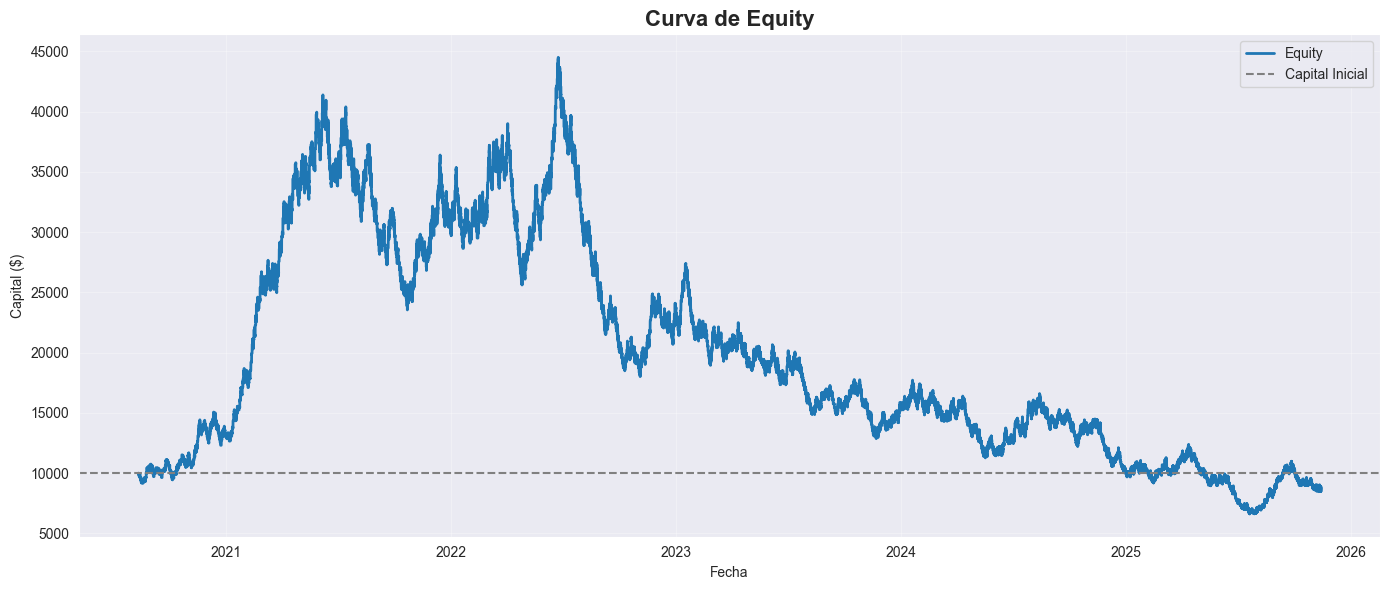

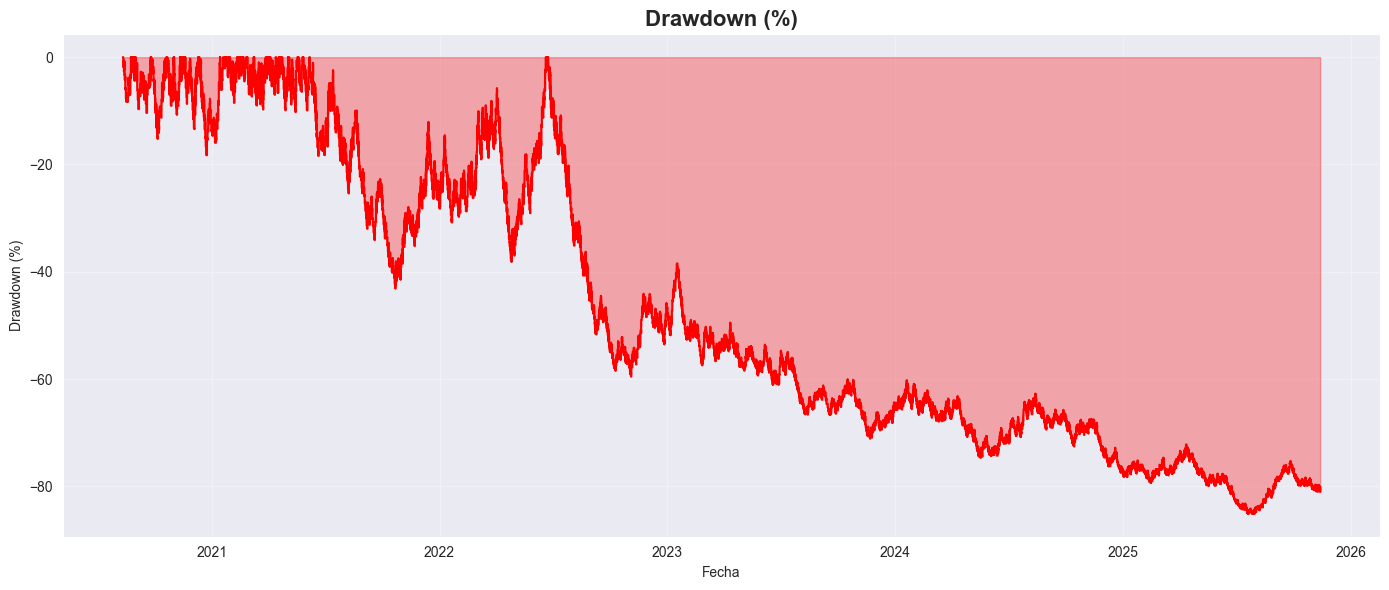

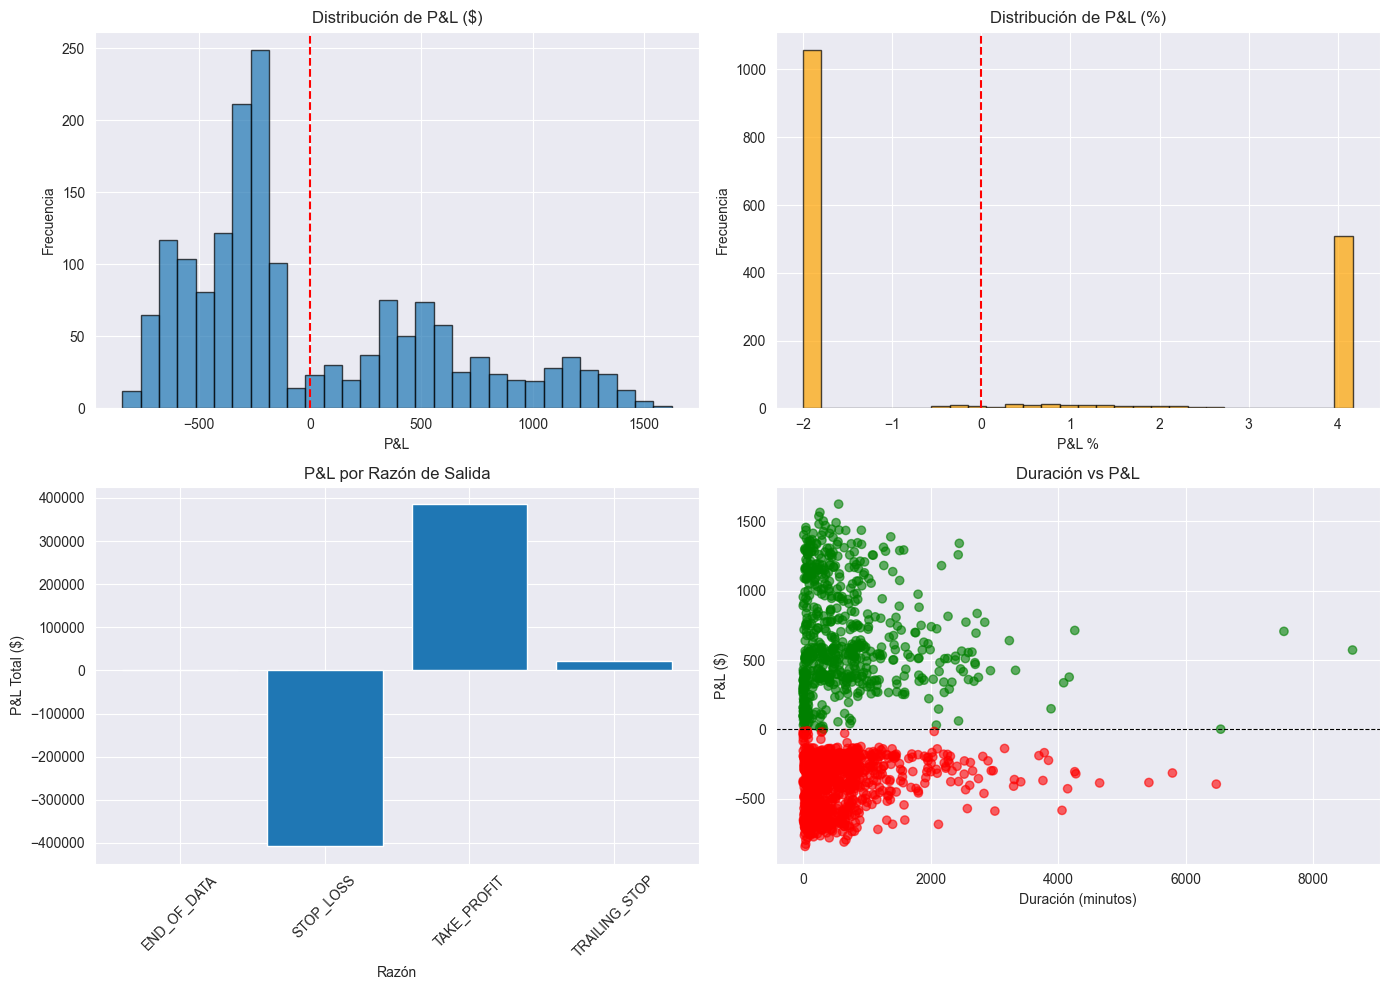

C:\Users\matal\AppData\Local\Temp\ipykernel_19768\3586021614.py:483: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  trades_df['month'] = pd.to_datetime(trades_df['entry_time']).dt.to_period('M')


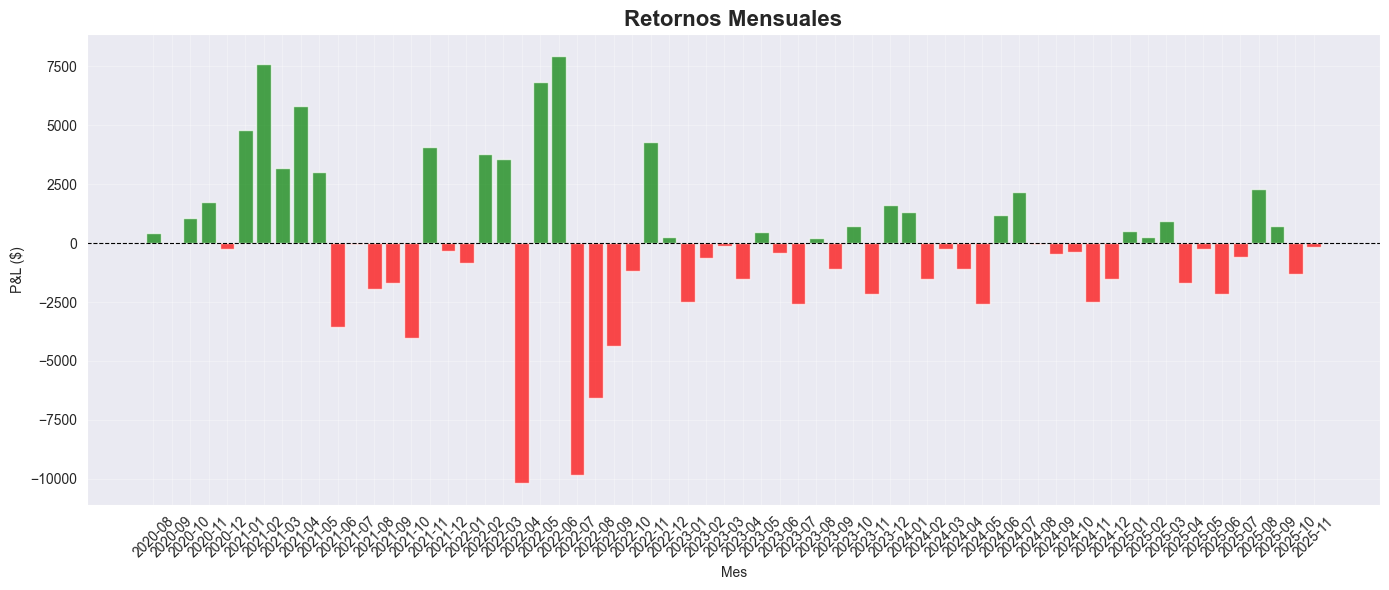


✅ Resultados guardados en CSV


In [6]:
# ============================================================================
# DETECCIÓN DE BREAKOUTS
# ============================================================================

def detect_breakouts(df):
    """
    Detecta breakouts alcistas y bajistas del rango de apertura
    """
    df_result = df.copy()

    # Inicializar columnas
    df_result['breakout_up'] = False
    df_result['breakout_down'] = False
    df_result['breakout_type'] = None

    # Solo procesar velas después del opening range
    mask_after_or = df_result['after_opening_range'] == True

    # Breakout alcista: high supera orb_high
    breakout_up_mask = (
        mask_after_or &
        (df_result['high'] > df_result['orb_high'])
    )

    # Breakout bajista: low rompe por debajo de orb_low
    breakout_down_mask = (
        mask_after_or &
        (df_result['low'] < df_result['orb_low'])
    )

    df_result.loc[breakout_up_mask, 'breakout_up'] = True
    df_result.loc[breakout_up_mask, 'breakout_type'] = 'UP'

    df_result.loc[breakout_down_mask, 'breakout_down'] = True
    df_result.loc[breakout_down_mask, 'breakout_type'] = 'DOWN'

    # Identificar PRIMER breakout de cada día
    df_result['first_breakout'] = False

    for trading_day in df_result['trading_day'].unique():
        day_mask = df_result['trading_day'] == trading_day
        day_data = df_result[day_mask]

        # Buscar primera vela con breakout
        breakout_indices = day_data[
            (day_data['breakout_up'] == True) |
            (day_data['breakout_down'] == True)
        ].index

        if len(breakout_indices) > 0:
            first_breakout_idx = breakout_indices[0]
            df_result.loc[first_breakout_idx, 'first_breakout'] = True

    return df_result


# ============================================================================
# REGLAS DE ENTRADA Y SALIDA
# ============================================================================

class ORBTradingRules:
    """
    Define las reglas de trading para el sistema ORB
    """

    def __init__(self,
                 stop_loss_pct=0.02,      # 2% stop loss
                 take_profit_pct=0.04,     # 4% take profit (R:R 1:2)
                 trailing_stop_pct=0.015,  # 1.5% trailing stop
                 use_trailing=True):

        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.trailing_stop_pct = trailing_stop_pct
        self.use_trailing = use_trailing

    def calculate_entry_long(self, row):
        """Calcula niveles para entrada larga"""
        entry_price = row['orb_high']
        stop_loss = entry_price * (1 - self.stop_loss_pct)
        take_profit = entry_price * (1 + self.take_profit_pct)

        return {
            'entry_price': entry_price,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'direction': 'LONG'
        }

    def calculate_entry_short(self, row):
        """Calcula niveles para entrada corta"""
        entry_price = row['orb_low']
        stop_loss = entry_price * (1 + self.stop_loss_pct)
        take_profit = entry_price * (1 - self.take_profit_pct)

        return {
            'entry_price': entry_price,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'direction': 'SHORT'
        }

    def check_exit_conditions(self, position, current_bar):
        """
        Verifica si se cumplen condiciones de salida
        Returns: (should_exit, exit_reason, exit_price)
        """
        if position is None:
            return False, None, None

        direction = position['direction']
        entry_price = position['entry_price']
        stop_loss = position['stop_loss']
        take_profit = position['take_profit']

        if direction == 'LONG':
            # Stop Loss
            if current_bar['low'] <= stop_loss:
                return True, 'STOP_LOSS', stop_loss

            # Take Profit
            if current_bar['high'] >= take_profit:
                return True, 'TAKE_PROFIT', take_profit

            # Trailing Stop
            if self.use_trailing:
                trailing_stop = current_bar['high'] * (1 - self.trailing_stop_pct)
                if current_bar['low'] <= trailing_stop and current_bar['high'] > entry_price * 1.01:
                    return True, 'TRAILING_STOP', trailing_stop

        elif direction == 'SHORT':
            # Stop Loss
            if current_bar['high'] >= stop_loss:
                return True, 'STOP_LOSS', stop_loss

            # Take Profit
            if current_bar['low'] <= take_profit:
                return True, 'TAKE_PROFIT', take_profit

            # Trailing Stop
            if self.use_trailing:
                trailing_stop = current_bar['low'] * (1 + self.trailing_stop_pct)
                if current_bar['high'] >= trailing_stop and current_bar['low'] < entry_price * 0.99:
                    return True, 'TRAILING_STOP', trailing_stop

        return False, None, None


# ============================================================================
# MOTOR DE BACKTESTING
# ============================================================================

class ORBBacktester:
    """
    Motor de backtesting para estrategia ORB
    """

    def __init__(self, df, rules, initial_capital=10000, position_size_pct=1.0):
        self.df = df
        self.rules = rules
        self.initial_capital = initial_capital
        self.position_size_pct = position_size_pct

        self.trades = []
        self.equity_curve = []
        self.current_position = None
        self.capital = initial_capital

    def run(self):
        """Ejecuta el backtest completo"""
        print("Iniciando backtesting...")

        for idx, row in self.df.iterrows():
            # Si no hay posición abierta, buscar entrada
            if self.current_position is None:
                if row['first_breakout'] == True:
                    self._enter_trade(row, idx)

            # Si hay posición abierta, verificar salida
            else:
                self._check_exit(row, idx)

            # Registrar equity
            current_equity = self._calculate_equity(row)
            self.equity_curve.append({
                'timestamp': idx,
                'equity': current_equity,
                'in_position': self.current_position is not None
            })

        # Cerrar posición si queda abierta al final
        if self.current_position is not None:
            last_row = self.df.iloc[-1]
            self._close_position(last_row, self.df.index[-1], 'END_OF_DATA')

        print(f"Backtesting completado. Total trades: {len(self.trades)}")
        return self.trades, pd.DataFrame(self.equity_curve)

    def _enter_trade(self, row, timestamp):
        """Ejecuta entrada en trade"""
        if row['breakout_type'] == 'UP':
            entry_info = self.rules.calculate_entry_long(row)
        elif row['breakout_type'] == 'DOWN':
            entry_info = self.rules.calculate_entry_short(row)
        else:
            return

        # Calcular tamaño de posición
        risk_amount = self.capital * self.position_size_pct
        position_size = risk_amount / entry_info['entry_price']

        self.current_position = {
            'entry_time': timestamp,
            'entry_price': entry_info['entry_price'],
            'stop_loss': entry_info['stop_loss'],
            'take_profit': entry_info['take_profit'],
            'direction': entry_info['direction'],
            'size': position_size,
            'trading_day': row['trading_day']
        }

        print(f"Entrada {entry_info['direction']} en {timestamp} @ {entry_info['entry_price']:.4f}")

    def _check_exit(self, row, timestamp):
        """Verifica condiciones de salida"""
        should_exit, exit_reason, exit_price = self.rules.check_exit_conditions(
            self.current_position, row
        )

        if should_exit:
            self._close_position(row, timestamp, exit_reason, exit_price)

    def _close_position(self, row, timestamp, exit_reason, exit_price=None):
        """Cierra posición y registra trade"""
        if exit_price is None:
            exit_price = row['close']

        position = self.current_position
        direction = position['direction']

        # Calcular P&L
        if direction == 'LONG':
            pnl = (exit_price - position['entry_price']) * position['size']
            pnl_pct = ((exit_price / position['entry_price']) - 1) * 100
        else:  # SHORT
            pnl = (position['entry_price'] - exit_price) * position['size']
            pnl_pct = ((position['entry_price'] / exit_price) - 1) * 100

        # Actualizar capital
        self.capital += pnl

        # Registrar trade
        trade_record = {
            'entry_time': position['entry_time'],
            'exit_time': timestamp,
            'direction': direction,
            'entry_price': position['entry_price'],
            'exit_price': exit_price,
            'size': position['size'],
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'trading_day': position['trading_day'],
            'duration_minutes': (timestamp - position['entry_time']).total_seconds() / 60
        }

        self.trades.append(trade_record)
        print(f"Salida {exit_reason} en {timestamp} @ {exit_price:.4f} | P&L: ${pnl:.2f} ({pnl_pct:.2f}%)")

        # Limpiar posición
        self.current_position = None

    def _calculate_equity(self, row):
        """Calcula equity actual"""
        if self.current_position is None:
            return self.capital

        # Calcular P&L no realizado
        position = self.current_position
        current_price = row['close']

        if position['direction'] == 'LONG':
            unrealized_pnl = (current_price - position['entry_price']) * position['size']
        else:
            unrealized_pnl = (position['entry_price'] - current_price) * position['size']

        return self.capital + unrealized_pnl


# ============================================================================
# MÉTRICAS DE PERFORMANCE
# ============================================================================

class PerformanceMetrics:
    """
    Calcula métricas de performance del backtest
    """

    def __init__(self, trades_df, equity_df, initial_capital):
        self.trades_df = trades_df
        self.equity_df = equity_df
        self.initial_capital = initial_capital

    def calculate_all_metrics(self):
        """Calcula todas las métricas"""
        if len(self.trades_df) == 0:
            return {"error": "No hay trades para analizar"}

        metrics = {}

        # Métricas básicas
        metrics['total_trades'] = len(self.trades_df)
        metrics['winning_trades'] = len(self.trades_df[self.trades_df['pnl'] > 0])
        metrics['losing_trades'] = len(self.trades_df[self.trades_df['pnl'] < 0])
        metrics['win_rate'] = (metrics['winning_trades'] / metrics['total_trades']) * 100

        # P&L
        metrics['total_pnl'] = self.trades_df['pnl'].sum()
        metrics['total_return_pct'] = ((self.equity_df['equity'].iloc[-1] / self.initial_capital) - 1) * 100

        # Estadísticas de trades
        winning_trades = self.trades_df[self.trades_df['pnl'] > 0]
        losing_trades = self.trades_df[self.trades_df['pnl'] < 0]

        metrics['avg_win'] = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        metrics['avg_loss'] = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        metrics['largest_win'] = winning_trades['pnl'].max() if len(winning_trades) > 0 else 0
        metrics['largest_loss'] = losing_trades['pnl'].min() if len(losing_trades) > 0 else 0

        # Profit Factor
        total_wins = winning_trades['pnl'].sum() if len(winning_trades) > 0 else 0
        total_losses = abs(losing_trades['pnl'].sum()) if len(losing_trades) > 0 else 1
        metrics['profit_factor'] = total_wins / total_losses if total_losses > 0 else float('inf')

        # Expectancy
        metrics['expectancy'] = self.trades_df['pnl'].mean()

        # Drawdown
        metrics['max_drawdown'], metrics['max_drawdown_pct'] = self._calculate_max_drawdown()

        # Sharpe Ratio (anualizado)
        metrics['sharpe_ratio'] = self._calculate_sharpe_ratio()

        # Duración promedio
        metrics['avg_duration_minutes'] = self.trades_df['duration_minutes'].mean()

        return metrics

    def _calculate_max_drawdown(self):
        """Calcula drawdown máximo"""
        equity = self.equity_df['equity'].values
        running_max = np.maximum.accumulate(equity)
        drawdown = equity - running_max
        max_dd = drawdown.min()
        max_dd_pct = (max_dd / running_max[np.argmin(drawdown)]) * 100
        return max_dd, max_dd_pct

    def _calculate_sharpe_ratio(self):
        """Calcula Sharpe Ratio anualizado"""
        returns = self.trades_df['pnl_pct'].values / 100
        if len(returns) < 2:
            return 0

        avg_return = returns.mean()
        std_return = returns.std()

        if std_return == 0:
            return 0

        # Anualizar (asumiendo ~250 días de trading)
        sharpe = (avg_return / std_return) * np.sqrt(250)
        return sharpe

    def print_summary(self):
        """Imprime resumen de métricas"""
        metrics = self.calculate_all_metrics()

        print("\n" + "="*70)
        print("RESUMEN DE PERFORMANCE")
        print("="*70)

        print(f"\nTotal Trades: {metrics['total_trades']}")
        print(f"Winning Trades: {metrics['winning_trades']} ({metrics['win_rate']:.2f}%)")
        print(f"Losing Trades: {metrics['losing_trades']}")

        print(f"\n💰 P&L Total: ${metrics['total_pnl']:.2f}")
        print(f"📈 Retorno Total: {metrics['total_return_pct']:.2f}%")

        print(f"\n✅ Promedio Ganancia: ${metrics['avg_win']:.2f}")
        print(f"❌ Promedio Pérdida: ${metrics['avg_loss']:.2f}")
        print(f"🏆 Mayor Ganancia: ${metrics['largest_win']:.2f}")
        print(f"💀 Mayor Pérdida: ${metrics['largest_loss']:.2f}")

        print(f"\n📊 Profit Factor: {metrics['profit_factor']:.2f}")
        print(f"🎯 Expectancy: ${metrics['expectancy']:.2f}")
        print(f"📉 Max Drawdown: ${metrics['max_drawdown']:.2f} ({metrics['max_drawdown_pct']:.2f}%)")
        print(f"📈 Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"⏱️  Duración Promedio: {metrics['avg_duration_minutes']:.1f} minutos")

        print("="*70 + "\n")

        return metrics


# ============================================================================
# VISUALIZACIONES
# ============================================================================

def plot_equity_curve(equity_df, initial_capital):
    """Grafica curva de equity"""
    plt.figure(figsize=(14, 6))

    plt.plot(equity_df['timestamp'], equity_df['equity'], linewidth=2, label='Equity')
    plt.axhline(y=initial_capital, color='gray', linestyle='--', label='Capital Inicial')

    plt.title('Curva de Equity', fontsize=16, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Capital ($)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_drawdown(equity_df):
    """Grafica drawdown"""
    equity = equity_df['equity'].values
    running_max = np.maximum.accumulate(equity)
    drawdown = ((equity - running_max) / running_max) * 100

    plt.figure(figsize=(14, 6))
    plt.fill_between(equity_df['timestamp'], drawdown, 0, alpha=0.3, color='red')
    plt.plot(equity_df['timestamp'], drawdown, color='red', linewidth=1.5)

    plt.title('Drawdown (%)', fontsize=16, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Drawdown (%)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_trade_distribution(trades_df):
    """Grafica distribución de P&L"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Histograma de P&L
    axes[0, 0].hist(trades_df['pnl'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(x=0, color='red', linestyle='--')
    axes[0, 0].set_title('Distribución de P&L ($)')
    axes[0, 0].set_xlabel('P&L')
    axes[0, 0].set_ylabel('Frecuencia')

    # Histograma de P&L %
    axes[0, 1].hist(trades_df['pnl_pct'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].axvline(x=0, color='red', linestyle='--')
    axes[0, 1].set_title('Distribución de P&L (%)')
    axes[0, 1].set_xlabel('P&L %')
    axes[0, 1].set_ylabel('Frecuencia')

    # P&L por razón de salida
    exit_reasons = trades_df.groupby('exit_reason')['pnl'].sum()
    axes[1, 0].bar(exit_reasons.index, exit_reasons.values)
    axes[1, 0].set_title('P&L por Razón de Salida')
    axes[1, 0].set_xlabel('Razón')
    axes[1, 0].set_ylabel('P&L Total ($)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Duración vs P&L
    colors = ['green' if x > 0 else 'red' for x in trades_df['pnl']]
    axes[1, 1].scatter(trades_df['duration_minutes'], trades_df['pnl'], c=colors, alpha=0.6)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1, 1].set_title('Duración vs P&L')
    axes[1, 1].set_xlabel('Duración (minutos)')
    axes[1, 1].set_ylabel('P&L ($)')

    plt.tight_layout()
    plt.show()


def plot_monthly_returns(trades_df):
    """Grafica retornos mensuales"""
    trades_df['month'] = pd.to_datetime(trades_df['entry_time']).dt.to_period('M')
    monthly_pnl = trades_df.groupby('month')['pnl'].sum()

    plt.figure(figsize=(14, 6))
    colors = ['green' if x > 0 else 'red' for x in monthly_pnl.values]
    plt.bar(range(len(monthly_pnl)), monthly_pnl.values, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

    plt.title('Retornos Mensuales', fontsize=16, fontweight='bold')
    plt.xlabel('Mes')
    plt.ylabel('P&L ($)')
    plt.xticks(range(len(monthly_pnl)), [str(m) for m in monthly_pnl.index], rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================================
# EJECUCIÓN COMPLETA
# ============================================================================

# 1. Detectar breakouts
print("Detectando breakouts...")
data_with_breakouts = detect_breakouts(data_with_orb)

# 2. Configurar reglas de trading
rules = ORBTradingRules(
    stop_loss_pct=0.02,
    take_profit_pct=0.04,
    trailing_stop_pct=0.015,
    use_trailing=True
)

# 3. Ejecutar backtest
backtester = ORBBacktester(
    df=data_with_breakouts,
    rules=rules,
    initial_capital=10000,
    position_size_pct=0.95
)

trades, equity_curve = backtester.run()

# 4. Convertir a DataFrame
trades_df = pd.DataFrame(trades)
print(f"\nPrimeros 10 trades:")
print(trades_df.head(10))

# 5. Calcular métricas
metrics_calculator = PerformanceMetrics(trades_df, equity_curve, 10000)
metrics = metrics_calculator.print_summary()

# 6. Visualizaciones
plot_equity_curve(equity_curve, 10000)
plot_drawdown(equity_curve)
plot_trade_distribution(trades_df)
plot_monthly_returns(trades_df)

# 7. Guardar resultados
trades_df.to_csv('orb_backtest_trades.csv', index=False)
equity_curve.to_csv('orb_backtest_equity.csv', index=False)
print("\n✅ Resultados guardados en CSV")